In [1]:
# !/usr/env python3

'''
Output:
video captioning model itself and produce loss curve

Usage:
main document to train the video captioning model
'''

# set up
from __future__ import print_function
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
from util import *
from model.video_caption import sequence_2_sequence_LSTM
from load_caption_feature import *
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load Data  
load caption Xtrain, Xtest, ytrain, ytest, video_train, video_test and save them. 

In [2]:
# load and save training data
num_frames = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_train_ind_above400.npy'
Xtrain_idx = np.load(idx_path)
labels = np.load(os.getcwd() + '/datasets/y_train_mapped_above400.npy')

# if all videos then 
num_videos = len(Xtrain_idx)

tic = datetime.now()
# for clearing memory convenience
model = vgg_16_pretrained()
Xtr, ytr = load_features(model, num_videos, num_frames, Xtrain_idx, labels, size = (224, 224, 3), train_test_flag='train')

processing videos...
process 70/4270
process 140/4270
process 210/4270
process 280/4270
process 350/4270
process 420/4270
process 490/4270
process 560/4270
process 630/4270
process 700/4270
process 770/4270
process 840/4270
process 910/4270
process 980/4270
process 1050/4270
process 1120/4270
process 1190/4270
process 1260/4270
process 1330/4270
process 1400/4270
process 1470/4270
process 1540/4270
process 1610/4270
process 1680/4270
process 1750/4270
process 1820/4270
process 1890/4270
process 1960/4270
process 2030/4270
process 2100/4270
process 2170/4270
process 2240/4270
process 2310/4270
process 2380/4270
process 2450/4270
process 2520/4270
process 2590/4270
process 2660/4270
process 2730/4270
process 2800/4270
process 2870/4270
process 2940/4270
process 3010/4270
process 3080/4270
process 3150/4270
process 3220/4270
process 3290/4270
process 3360/4270
process 3430/4270
process 3500/4270
process 3570/4270
process 3640/4270
process 3710/4270
process 3780/4270
process 3850/4270
proc

In [5]:
# clear memory
# del Xtr
# del ytr
model = None
gc.collect()

0

In [6]:
# load and save test data
num_frames_test = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_test_ind_above400.npy'
Xtest_idx = np.load(idx_path)
ytest = np.load(os.getcwd() + '/datasets/y_test_mapped_above400.npy')

# if all videos then 
num_videos_test = len(Xtest_idx)

model = vgg_16_pretrained()
Xte, yte = load_features(model, num_videos_test, num_frames_test, video_idx = Xtest_idx, labels = ytest, size = (224, 224, 3), train_test_flag='test')

processing videos...
process 30/1830
process 60/1830
process 90/1830
process 120/1830
process 150/1830
process 180/1830
process 210/1830
process 240/1830
process 270/1830
process 300/1830
process 330/1830
process 360/1830
process 390/1830
process 420/1830
process 450/1830
process 480/1830
process 510/1830
process 540/1830
process 570/1830
process 600/1830
process 630/1830
process 660/1830
process 690/1830
process 720/1830
process 750/1830
process 780/1830
process 810/1830
process 840/1830
process 870/1830
process 900/1830
process 930/1830
process 960/1830
process 990/1830
process 1020/1830
process 1050/1830
process 1080/1830
process 1110/1830
process 1140/1830
process 1170/1830
process 1200/1830
process 1230/1830
process 1260/1830
process 1290/1830
process 1320/1830
process 1350/1830
process 1380/1830
process 1410/1830
process 1440/1830
process 1470/1830
process 1500/1830
process 1530/1830
process 1560/1830
process 1590/1830
process 1620/1830
process 1650/1830
process 1680/1830
process

In [10]:
# clean memory
# del Xte
# del yte
model = None
gc.collect()

0

In [7]:
curr = os.getcwd() + '/datasets'
vid_ls = np.load(curr + '/videoIdtrain_allCap_15frames.npy')

In [11]:
Xtr = np.load(curr + '/Xtrain_allCap_15frames.npy')

In [18]:
Xtr = Xtr.reshape((-1, 15, 4096))
print('Xtrain shape: ', Xtr.shape)
assert Xtr.shape[0] == len(vid_ls)
input_frames = {}
for i in range(Xtr.shape[0]):
    vid = vid_ls[i]
    input_frames[vid] = Xtr[i]
# save input_frames
import pickle
pickle.dump(input_frames, open(curr+ '/input_frames_train.pickle', 'wb'))

Xtrain shape:  (4270, 15, 4096)


In [20]:
Xte = np.load(curr + '/Xtest_allCap_15frames.npy')
Xte = Xte.reshape((-1, 15, 4096))
print('Xtest shape: ', Xte.shape)
vid_test = np.load(curr + '/videoIdtest_allCap_15frames.npy')
assert Xte.shape[0] == len(vid_test)
input_frames_test = {}
for i in range(Xte.shape[0]):
    vid = vid_test[i]
    input_frames_test[vid] = Xtr[i]
# save input_frames
import pickle
pickle.dump(input_frames_test, open(curr+ '/input_frames_test.pickle', 'wb'))

Xtest shape:  (1830, 15, 4096)


## Model setup and train

### Model Configuration and Parameters

In [2]:
# define parameters
lr = 1e-5
hidden_size = 100
state_size = 100
batch_size = 64
voc_size = 6169
epoch = 100
word_dim = 50

logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "baseline_1", "name of the model")
tf.app.flags.DEFINE_integer("state_size", state_size, "Size of each model layer.")
tf.app.flags.DEFINE_float("learning_rate", lr, "Base Learning rate.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 4096, "input size for each frame")
tf.app.flags.DEFINE_integer("batch_size", batch_size, "how many videos put per run")
tf.app.flags.DEFINE_integer("max_sentence_length", 20, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", word_dim, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("voc_size", voc_size, "vocabulary size")
tf.app.flags.DEFINE_integer("n_epochs", epoch, "number of epoch to run")
tf.app.flags.DEFINE_integer("num_frames", 15, "number of frames per video")
tf.app.flags.DEFINE_integer("hidden_size", hidden_size, "output size of LSTM encoder and decoder")
FLAGS = tf.app.flags.FLAGS        

### Load Training Data

In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

curPath = os.getcwd()
dataPath = curPath + "/datasets/"

# only pick first 100 for debugging purpose
# load data
sample_size = 4270
wvector_dim = 50
is_training = True
input_frames_train, captions_train, \
        word_dict, word2Index, index2Word = load_caption_data(sample_size, dataPath, train = is_training)
word_embedding = word_embedding_array(word_dict, wvector_dim, word2Index) 
print('Finish loading training data!')

Finish loading training data!


### Build Model Graph

In [4]:
# build model graph
tf.reset_default_graph()
model = sequence_2_sequence_LSTM(word_embedding, FLAGS)
model.build()

start building model ...
total number of parameter 2402269


In [5]:
# check variables
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/weights:0' shape=(4196, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/weights:0' shape=(250, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_scores/kernel:0' shape=(100, 6169) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_scores/bias:0' shape=(6169,) dtype=float32_ref>


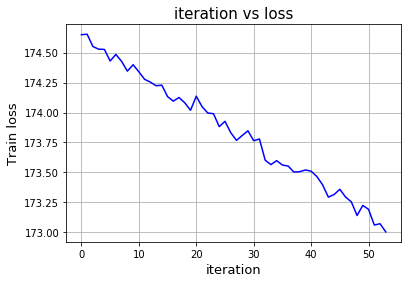

  1/100 [..............................] - ETA: 1614s - train loss: 173.8435 - dev loss: 173.0827

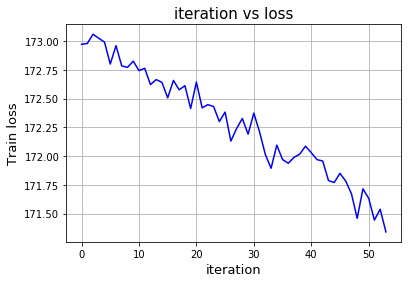

  2/100 [..............................] - ETA: 1560s - train loss: 172.2853 - dev loss: 171.3945

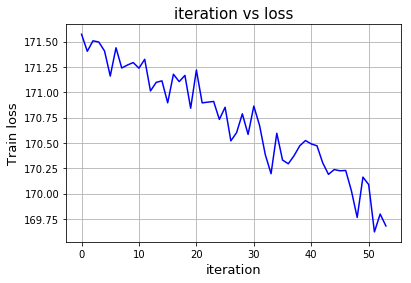

  3/100 [..............................] - ETA: 1531s - train loss: 170.7177 - dev loss: 169.6772

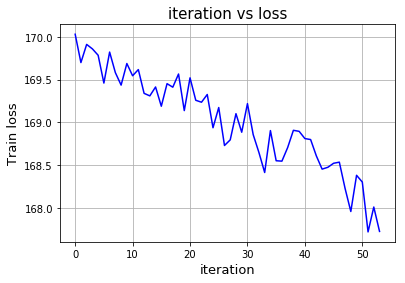

  4/100 [>.............................] - ETA: 1513s - train loss: 169.0076 - dev loss: 167.8469

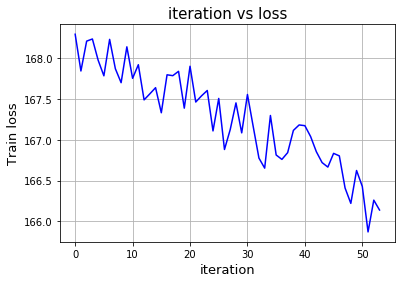

  5/100 [>.............................] - ETA: 1496s - train loss: 167.2721 - dev loss: 166.0323

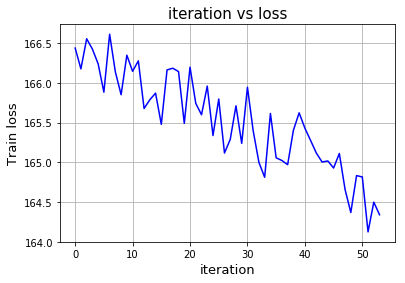

  6/100 [>.............................] - ETA: 1484s - train loss: 165.5224 - dev loss: 164.2324

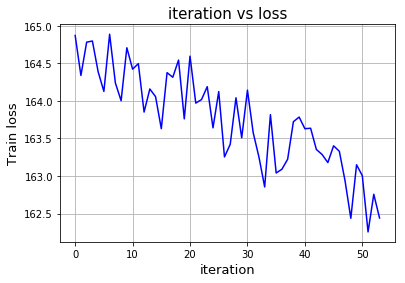

  7/100 [=>............................] - ETA: 1468s - train loss: 163.7554 - dev loss: 162.4906

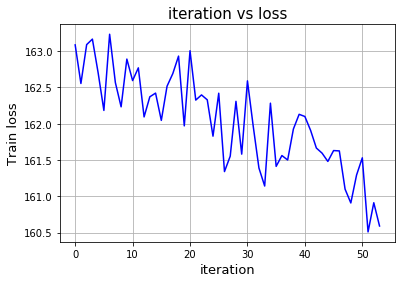

  8/100 [=>............................] - ETA: 1451s - train loss: 162.0355 - dev loss: 160.8287

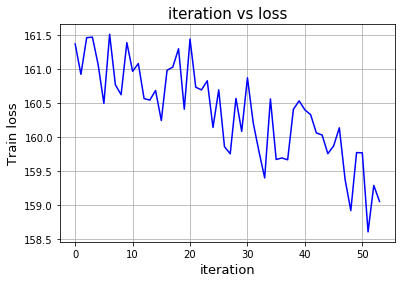

  9/100 [=>............................] - ETA: 1434s - train loss: 160.3694 - dev loss: 159.2010

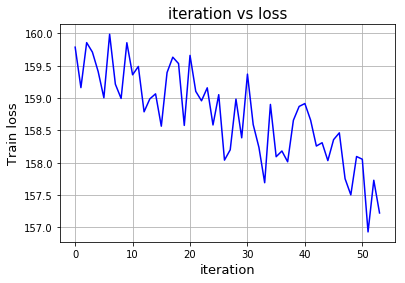

 10/100 [==>...........................] - ETA: 1417s - train loss: 158.7285 - dev loss: 157.5959

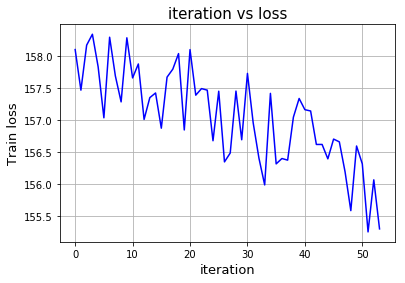

 11/100 [==>...........................] - ETA: 1401s - train loss: 157.0553 - dev loss: 156.0157

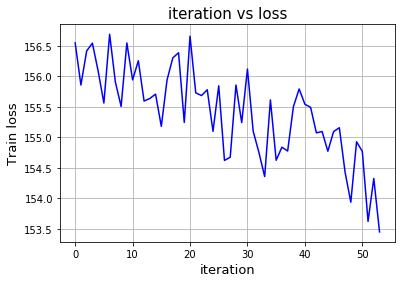

 12/100 [==>...........................] - ETA: 1385s - train loss: 155.4113 - dev loss: 154.4502

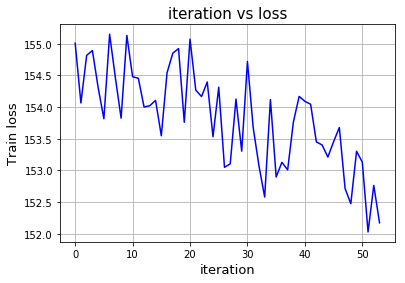

 13/100 [==>...........................] - ETA: 1370s - train loss: 153.8257 - dev loss: 152.8969

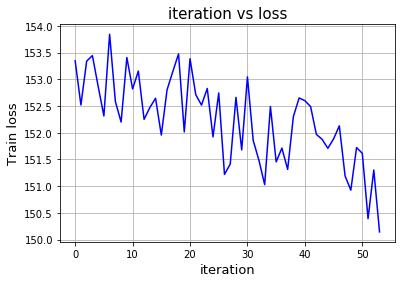

 14/100 [===>..........................] - ETA: 1355s - train loss: 152.2412 - dev loss: 151.3478

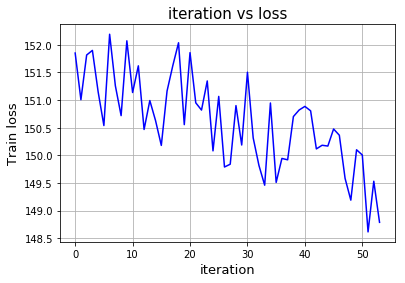

 15/100 [===>..........................] - ETA: 1339s - train loss: 150.6196 - dev loss: 149.7934

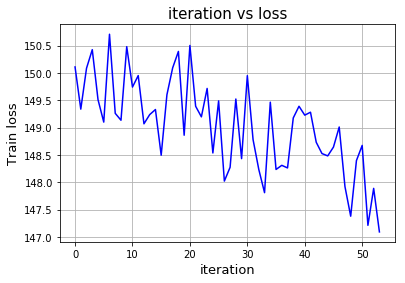

 16/100 [===>..........................] - ETA: 1323s - train loss: 149.0380 - dev loss: 148.2463

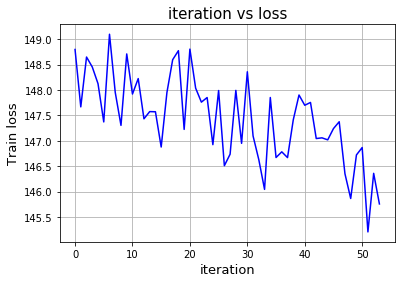

 17/100 [====>.........................] - ETA: 1307s - train loss: 147.4359 - dev loss: 146.6884

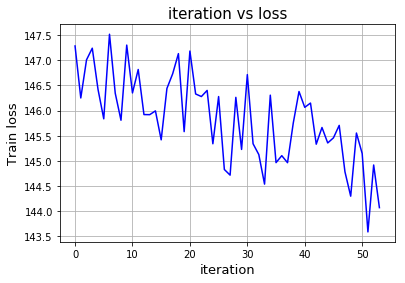

 18/100 [====>.........................] - ETA: 1291s - train loss: 145.8412 - dev loss: 145.1592

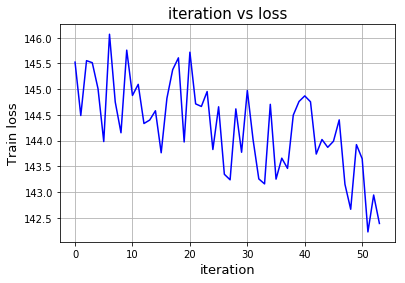

 19/100 [====>.........................] - ETA: 1274s - train loss: 144.2861 - dev loss: 143.6790

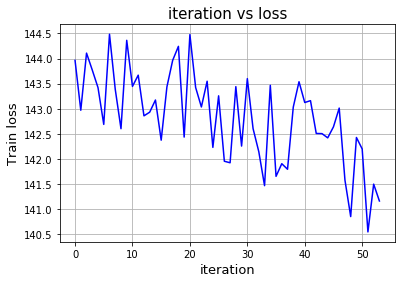

 20/100 [=====>........................] - ETA: 1258s - train loss: 142.8260 - dev loss: 142.2365

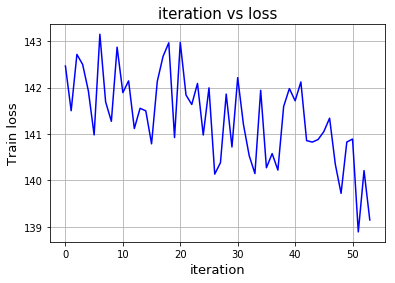

 21/100 [=====>........................] - ETA: 1242s - train loss: 141.3479 - dev loss: 140.8231

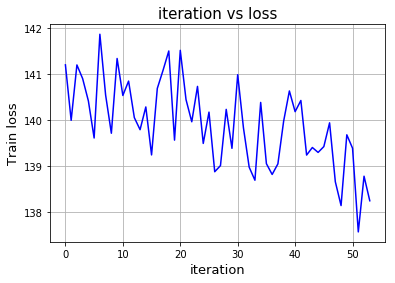

 22/100 [=====>........................] - ETA: 1226s - train loss: 139.9045 - dev loss: 139.4361

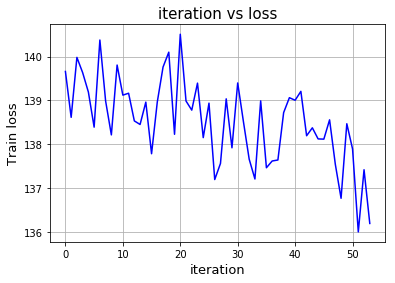

 23/100 [=====>........................] - ETA: 1210s - train loss: 138.5303 - dev loss: 138.0777

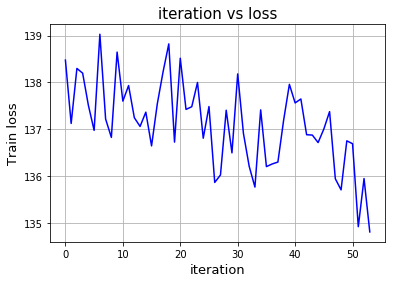

 24/100 [======>.......................] - ETA: 1195s - train loss: 137.1154 - dev loss: 136.7440

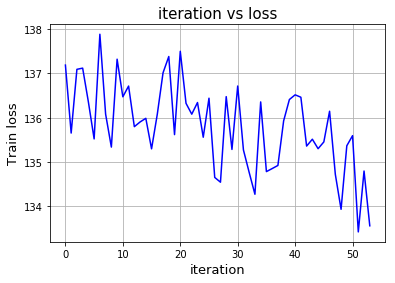

 25/100 [======>.......................] - ETA: 1179s - train loss: 135.8061 - dev loss: 135.4430

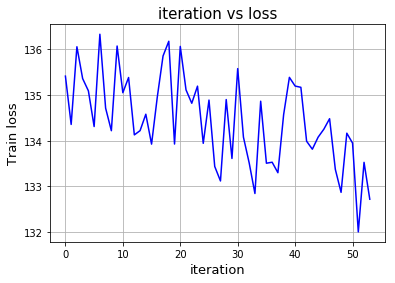

 26/100 [======>.......................] - ETA: 1163s - train loss: 134.4444 - dev loss: 134.1694

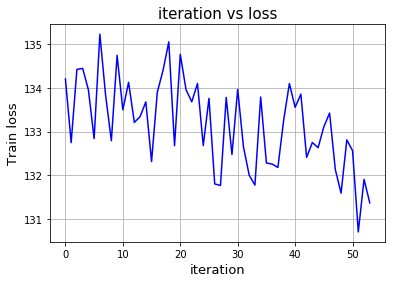

 27/100 [=======>......................] - ETA: 1136s - train loss: 133.1702 - dev loss: 132.9225

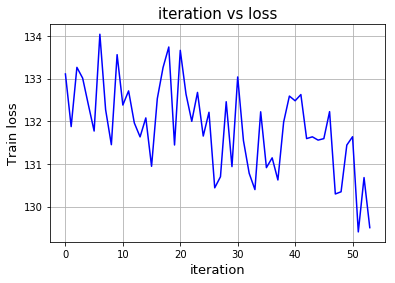

 28/100 [=======>......................] - ETA: 1108s - train loss: 131.8705 - dev loss: 131.7002

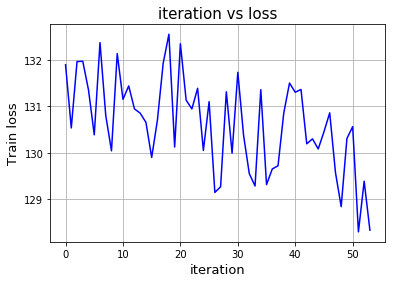

 29/100 [=======>......................] - ETA: 1081s - train loss: 130.6241 - dev loss: 130.5017

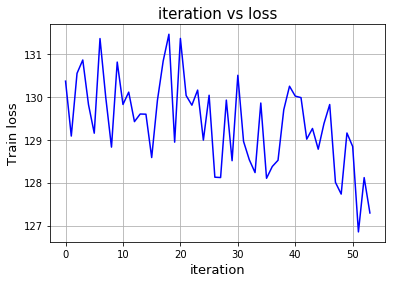

 30/100 [========>.....................] - ETA: 1055s - train loss: 129.3958 - dev loss: 129.3292

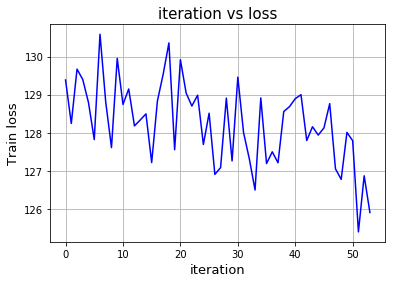

 31/100 [========>.....................] - ETA: 1030s - train loss: 128.2493 - dev loss: 128.1799

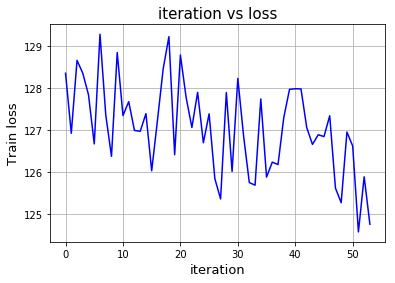

 32/100 [========>.....................] - ETA: 1006s - train loss: 127.0666 - dev loss: 127.0522

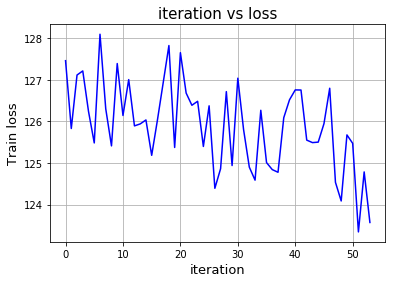

 33/100 [========>.....................] - ETA: 982s - train loss: 125.9074 - dev loss: 125.9476 

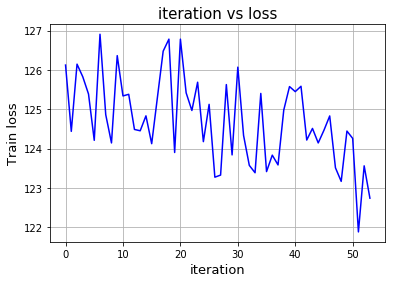

 34/100 [=========>....................] - ETA: 960s - train loss: 124.7159 - dev loss: 124.8634

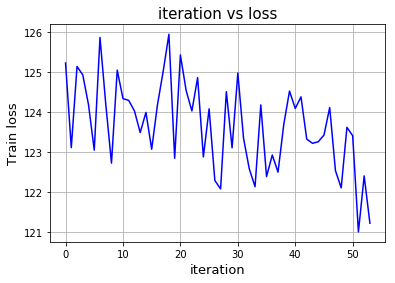

 35/100 [=========>....................] - ETA: 938s - train loss: 123.6649 - dev loss: 123.7971

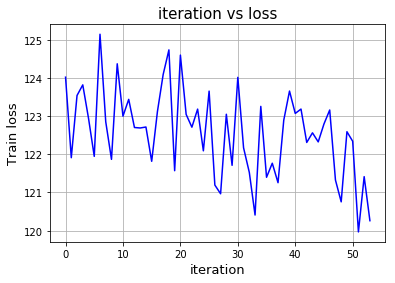

 36/100 [=========>....................] - ETA: 917s - train loss: 122.5719 - dev loss: 122.7506

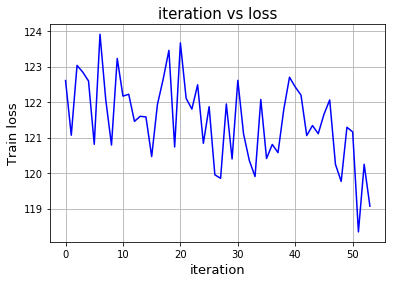

 37/100 [==========>...................] - ETA: 896s - train loss: 121.4888 - dev loss: 121.7223

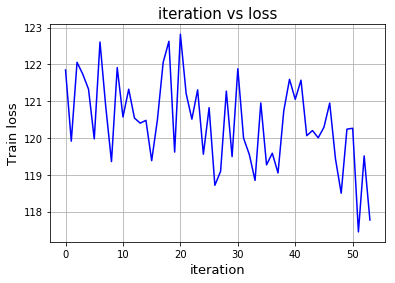

 38/100 [==========>...................] - ETA: 876s - train loss: 120.4178 - dev loss: 120.7100

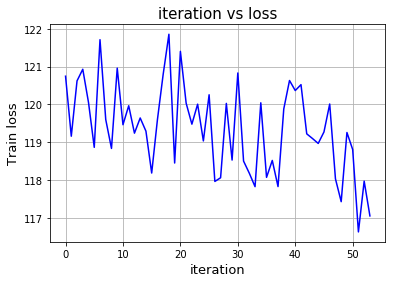

 39/100 [==========>...................] - ETA: 856s - train loss: 119.3674 - dev loss: 119.7141

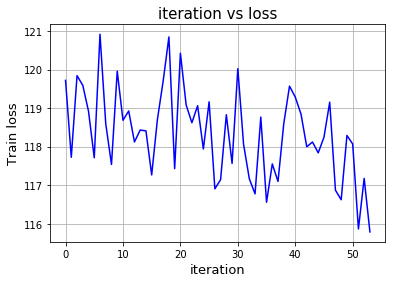

 40/100 [===========>..................] - ETA: 837s - train loss: 118.3346 - dev loss: 118.7337

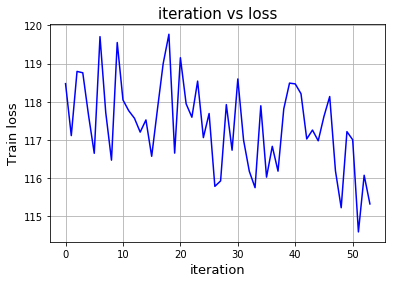

 41/100 [===========>..................] - ETA: 818s - train loss: 117.3905 - dev loss: 117.7677

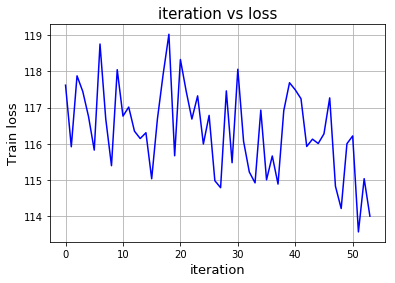

 42/100 [===========>..................] - ETA: 799s - train loss: 116.3725 - dev loss: 116.8160

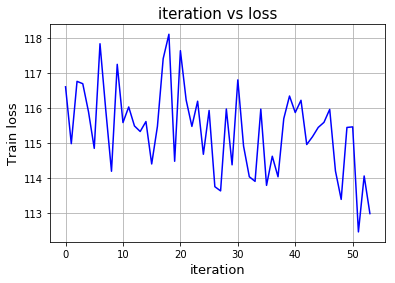

 43/100 [===========>..................] - ETA: 781s - train loss: 115.3817 - dev loss: 115.8759

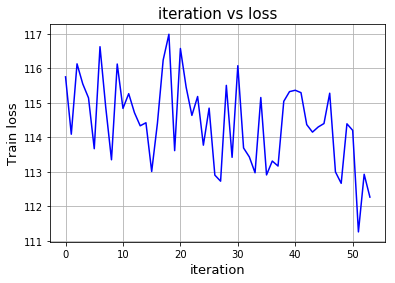

 44/100 [============>.................] - ETA: 764s - train loss: 114.4288 - dev loss: 114.9504

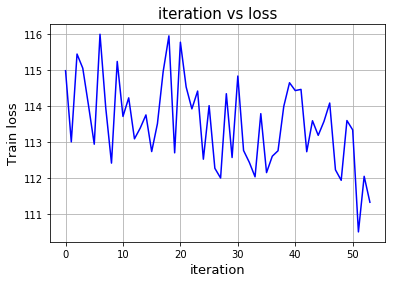

 45/100 [============>.................] - ETA: 746s - train loss: 113.5265 - dev loss: 114.0387

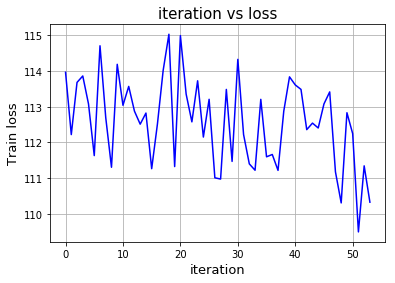

 46/100 [============>.................] - ETA: 729s - train loss: 112.5832 - dev loss: 113.1416

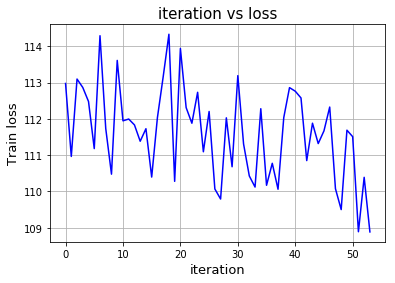

 47/100 [=============>................] - ETA: 712s - train loss: 111.6112 - dev loss: 112.2594

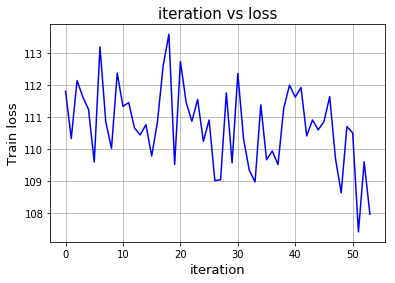

 48/100 [=============>................] - ETA: 695s - train loss: 110.7061 - dev loss: 111.3903

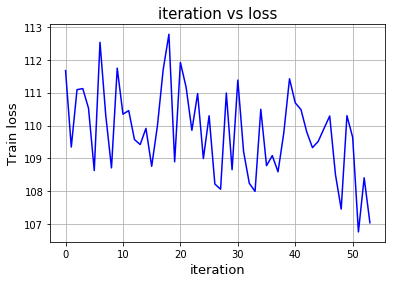

 49/100 [=============>................] - ETA: 679s - train loss: 109.8117 - dev loss: 110.5370

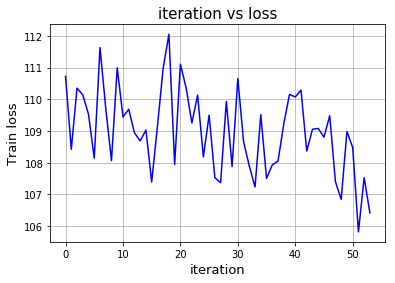

 50/100 [==============>...............] - ETA: 663s - train loss: 108.9948 - dev loss: 109.6984

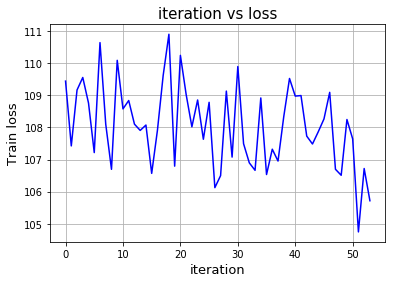

 51/100 [==============>...............] - ETA: 647s - train loss: 108.0561 - dev loss: 108.8725

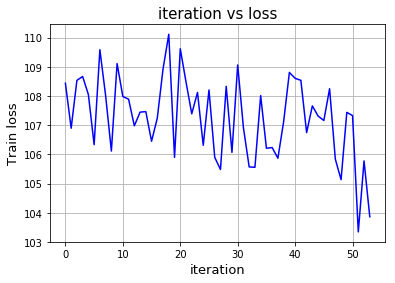

 52/100 [==============>...............] - ETA: 632s - train loss: 107.2648 - dev loss: 108.0620

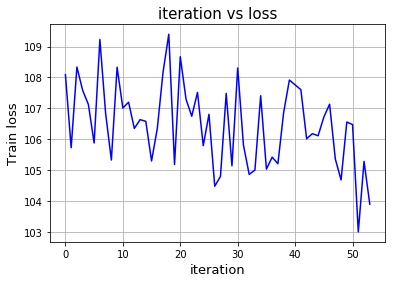

 53/100 [==============>...............] - ETA: 616s - train loss: 106.4796 - dev loss: 107.2631

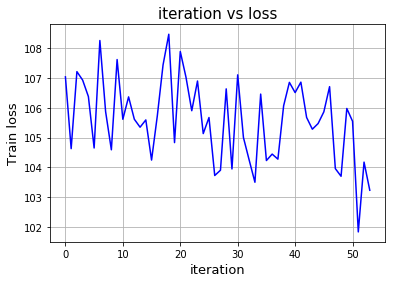

 54/100 [===============>..............] - ETA: 604s - train loss: 105.5984 - dev loss: 106.4791

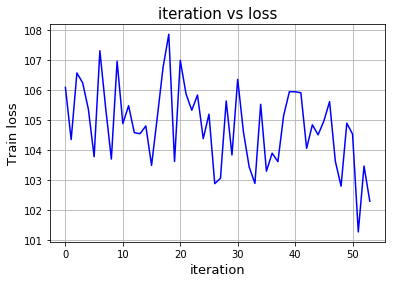

 55/100 [===============>..............] - ETA: 593s - train loss: 104.7969 - dev loss: 105.7067

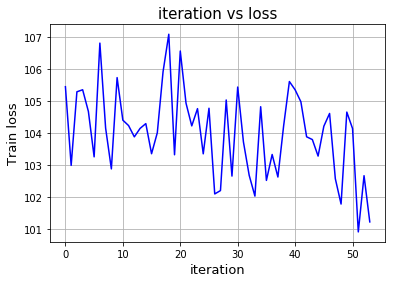

 56/100 [===============>..............] - ETA: 580s - train loss: 104.0225 - dev loss: 104.9471

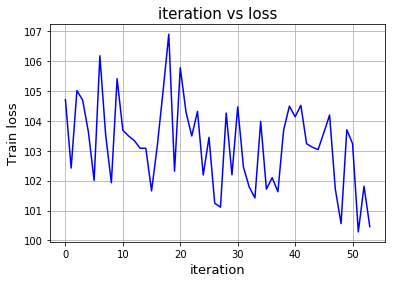

 57/100 [================>.............] - ETA: 565s - train loss: 103.2050 - dev loss: 104.1994

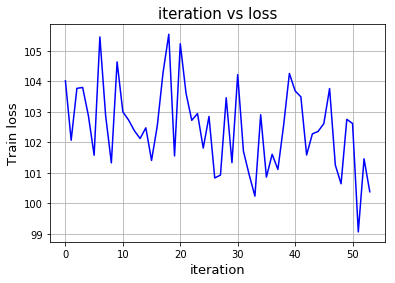

 58/100 [================>.............] - ETA: 550s - train loss: 102.4904 - dev loss: 103.4637

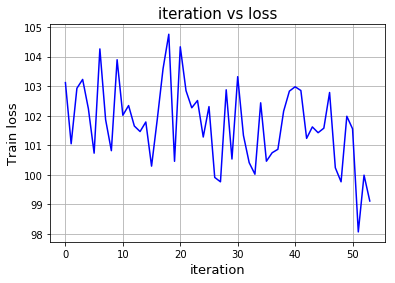

 59/100 [================>.............] - ETA: 535s - train loss: 101.7181 - dev loss: 102.7409

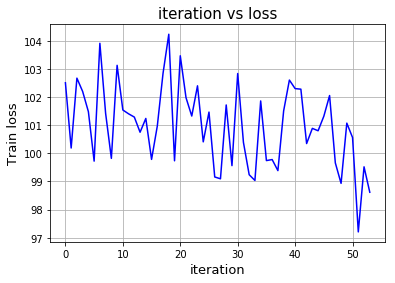

 60/100 [=================>............] - ETA: 520s - train loss: 100.9854 - dev loss: 102.0286

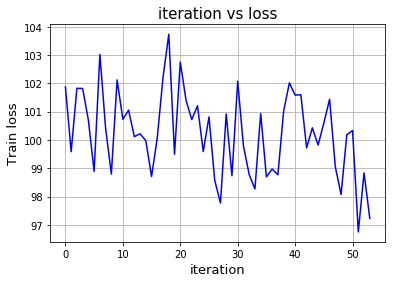

 61/100 [=================>............] - ETA: 506s - train loss: 100.2377 - dev loss: 101.3290

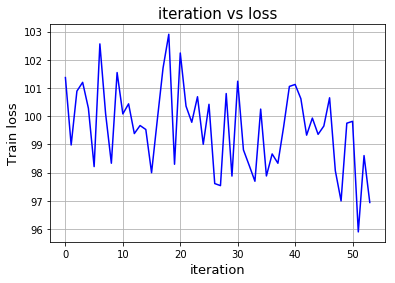

 62/100 [=================>............] - ETA: 491s - train loss: 99.5965 - dev loss: 100.6406 

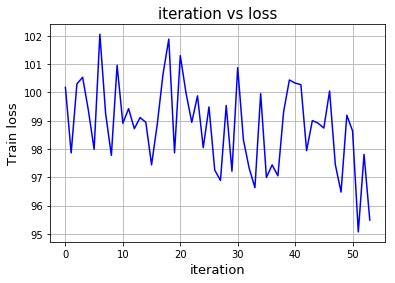

 63/100 [=================>............] - ETA: 477s - train loss: 98.8213 - dev loss: 99.9635 

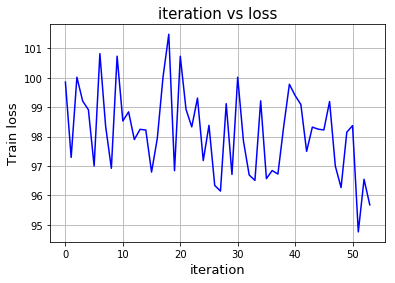

 64/100 [==================>...........] - ETA: 463s - train loss: 98.1541 - dev loss: 99.2966

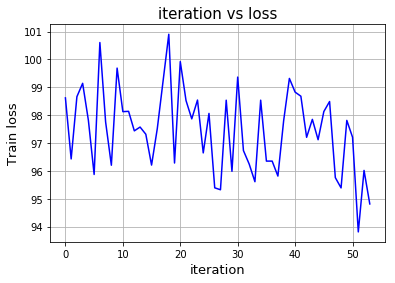

 65/100 [==================>...........] - ETA: 449s - train loss: 97.4715 - dev loss: 98.6406

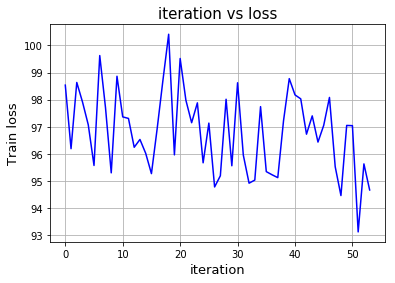

 66/100 [==================>...........] - ETA: 435s - train loss: 96.8193 - dev loss: 97.9968

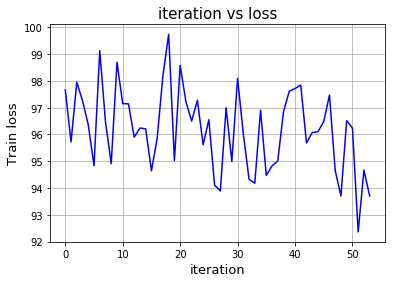

 67/100 [===================>..........] - ETA: 421s - train loss: 96.1929 - dev loss: 97.3659

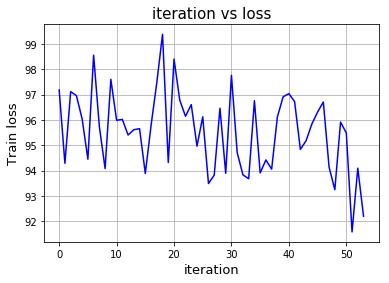

 68/100 [===================>..........] - ETA: 407s - train loss: 95.5511 - dev loss: 96.7450

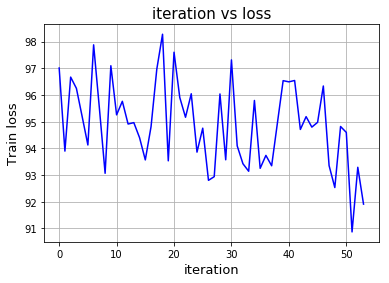

 69/100 [===================>..........] - ETA: 393s - train loss: 94.8860 - dev loss: 96.1347

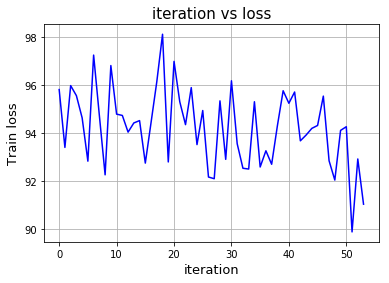

 70/100 [====================>.........] - ETA: 380s - train loss: 94.2181 - dev loss: 95.5329

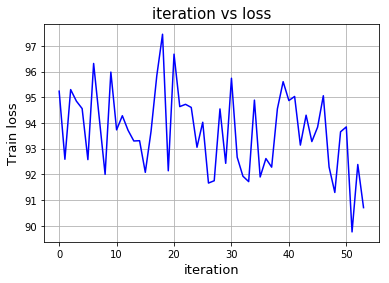

 71/100 [====================>.........] - ETA: 366s - train loss: 93.6755 - dev loss: 94.9422

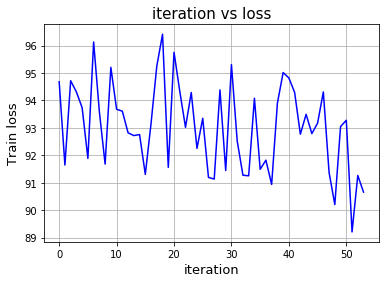

 72/100 [====================>.........] - ETA: 353s - train loss: 93.0425 - dev loss: 94.3601

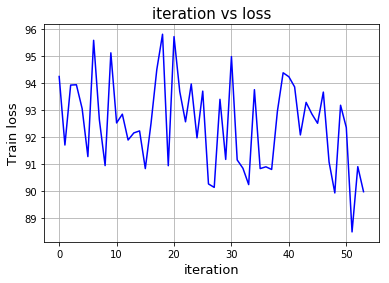

 73/100 [====================>.........] - ETA: 339s - train loss: 92.4879 - dev loss: 93.7887

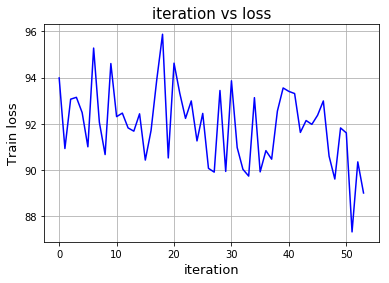

 74/100 [=====================>........] - ETA: 326s - train loss: 91.9230 - dev loss: 93.2266

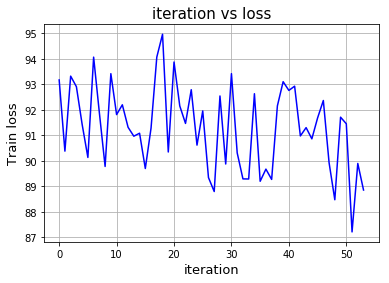

 75/100 [=====================>........] - ETA: 313s - train loss: 91.3020 - dev loss: 92.6748

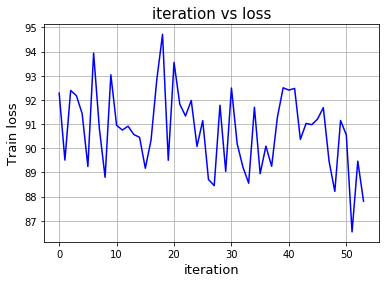

 76/100 [=====================>........] - ETA: 299s - train loss: 90.7293 - dev loss: 92.1337

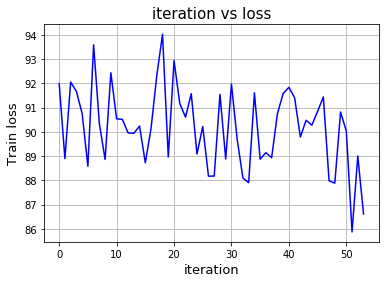

 77/100 [======================>.......] - ETA: 286s - train loss: 90.1788 - dev loss: 91.6015

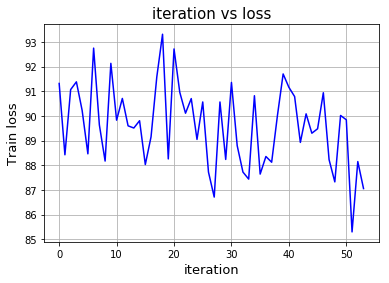

 78/100 [======================>.......] - ETA: 273s - train loss: 89.6139 - dev loss: 91.0772

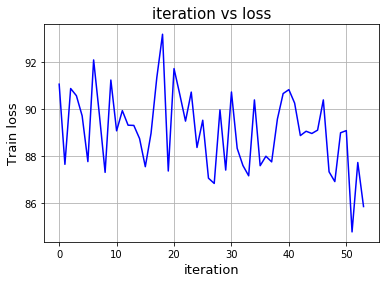

 79/100 [======================>.......] - ETA: 260s - train loss: 89.0792 - dev loss: 90.5646

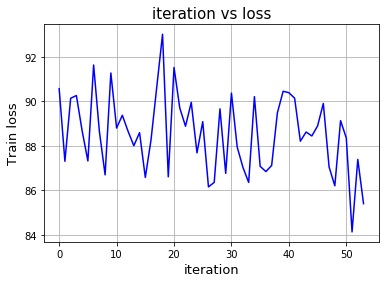

 80/100 [=======================>......] - ETA: 248s - train loss: 88.5621 - dev loss: 90.0610

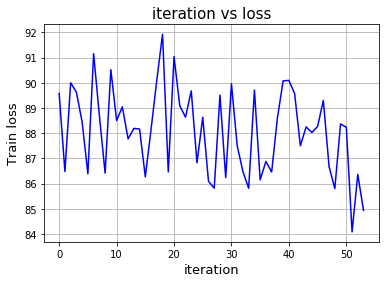

 81/100 [=======================>......] - ETA: 235s - train loss: 88.0833 - dev loss: 89.5672

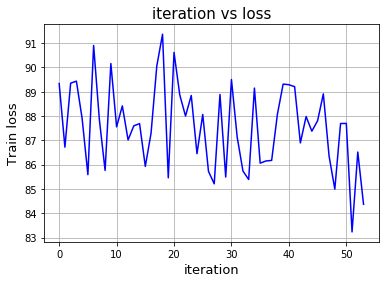

 82/100 [=======================>......] - ETA: 222s - train loss: 87.5657 - dev loss: 89.0835

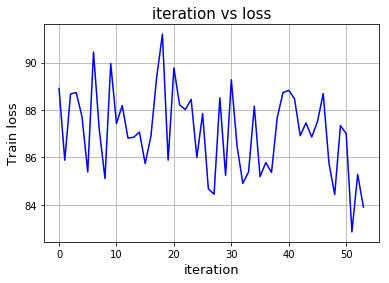

 83/100 [=======================>......] - ETA: 209s - train loss: 87.0883 - dev loss: 88.6093

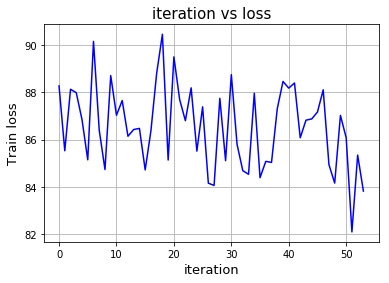

 84/100 [========================>.....] - ETA: 197s - train loss: 86.5599 - dev loss: 88.1431

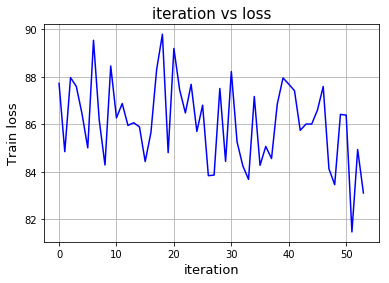

 85/100 [========================>.....] - ETA: 184s - train loss: 86.0975 - dev loss: 87.6870

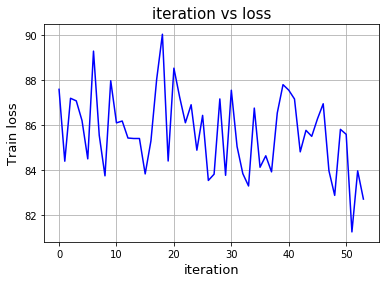

 86/100 [========================>.....] - ETA: 171s - train loss: 85.6708 - dev loss: 87.2408

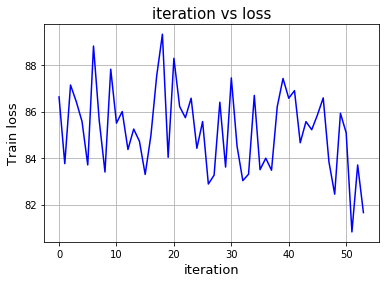

 87/100 [=========================>....] - ETA: 159s - train loss: 85.2116 - dev loss: 86.8019

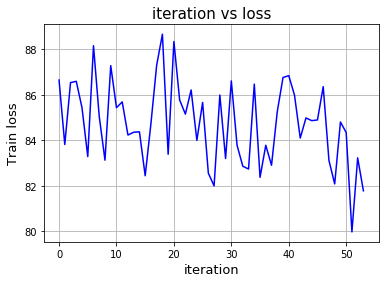

 88/100 [=========================>....] - ETA: 146s - train loss: 84.7477 - dev loss: 86.3749

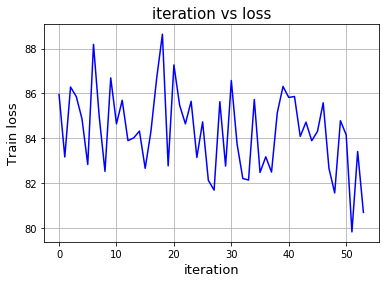

 89/100 [=========================>....] - ETA: 134s - train loss: 84.3254 - dev loss: 85.9532

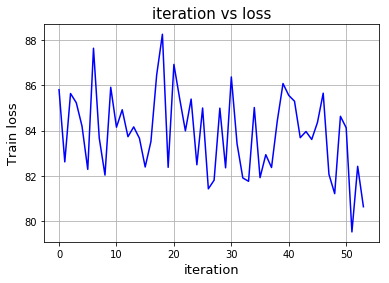

 90/100 [==========================>...] - ETA: 122s - train loss: 83.9155 - dev loss: 85.5421

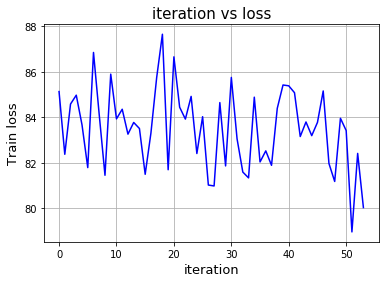

 91/100 [==========================>...] - ETA: 109s - train loss: 83.4941 - dev loss: 85.1415

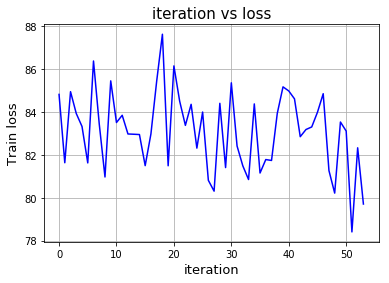

 92/100 [==========================>...] - ETA: 97s - train loss: 83.1148 - dev loss: 84.7474 

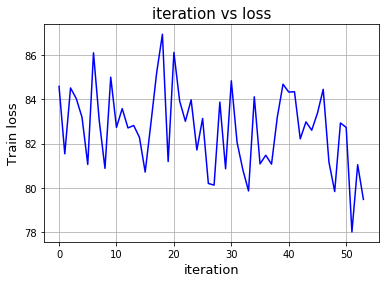

 93/100 [==========================>...] - ETA: 85s - train loss: 82.6818 - dev loss: 84.3624

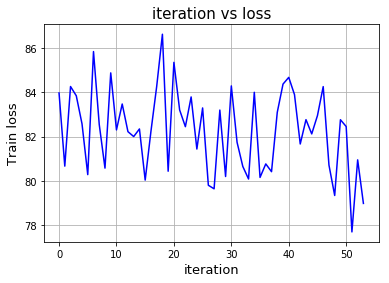

 94/100 [===========================>..] - ETA: 72s - train loss: 82.2696 - dev loss: 83.9859

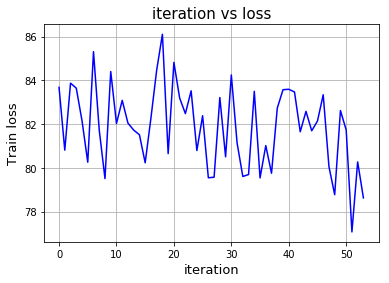

 95/100 [===========================>..] - ETA: 60s - train loss: 81.8852 - dev loss: 83.6184

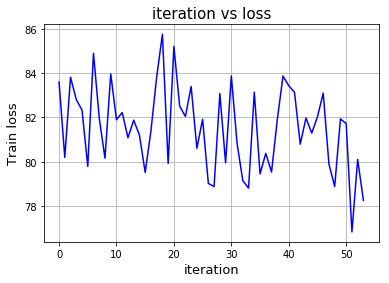

 96/100 [===========================>..] - ETA: 48s - train loss: 81.5395 - dev loss: 83.2593

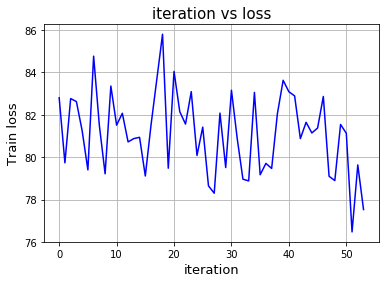

 97/100 [============================>.] - ETA: 36s - train loss: 81.1356 - dev loss: 82.9063

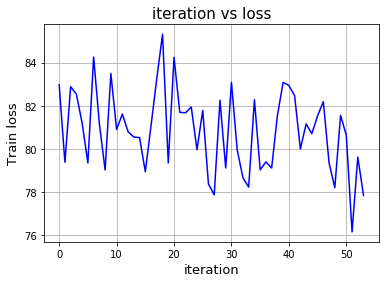

 98/100 [============================>.] - ETA: 24s - train loss: 80.8522 - dev loss: 82.5653

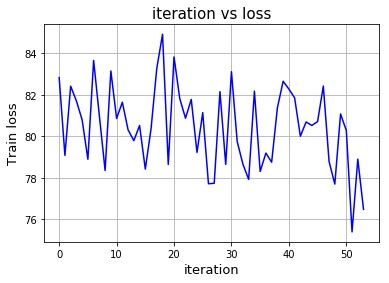

 99/100 [============================>.] - ETA: 12s - train loss: 80.4510 - dev loss: 82.2295

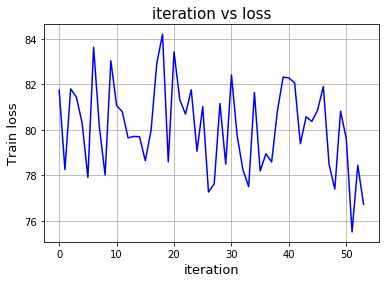

100/100 [==============================] - 1222s - train loss: 80.1136 - dev loss: 81.9040   


In [5]:
# run training mode
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    out = model.train(sess, (input_frames_train, captions_train), verbose = True)

In [9]:
# unpack
val_loss, tr_loss, tr_pred, val_pred, train_vid, val_vid = out

### Plot Learning Curves

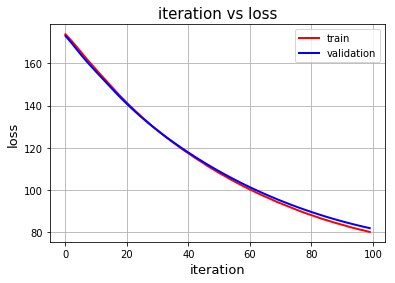

In [10]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/caption_learning_curve.png')

In [10]:
# check captions
batch_size = 24
# sample = tr_pred[idx] # training
# # sample = val_pred[idx] # validation 
# words = []
# embed_train = False # whether train embedding word

captions = {k: v for k, v in captions_train}
# caption check
for j in range(batch_size):
    words = []
    trues = []
    sample = tr_pred[j]
    vid = train_vid[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2Word[i]
        true = index2Word[cap[idx]]
        if word not in ['<START>', '<END>', '<pad>']:
            words.append(word)
        if true not in ['<START>', '<END>', '<pad>']:
            trues.append(true)   
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

Pred Caption:  a a a a a
True Caption:  two children are fighting with small sticks
--------------------------------------------------
Pred Caption:  a a a and
True Caption:  a video game is played
--------------------------------------------------
Pred Caption:  a a a a a and in and and a
True Caption:  a cabinet is opening its doors to reveal what is inside it
--------------------------------------------------
Pred Caption:  a a a the and
True Caption:  description of a green paper airplane
--------------------------------------------------
Pred Caption:  a a a
True Caption:  people are performing a party
--------------------------------------------------
Pred Caption:  a and a a a
True Caption:  dark outdoor people all around
--------------------------------------------------
Pred Caption:  a and and and and the the a
True Caption:  two men are talking each other while one women seating beside one man
--------------------------------------------------
Pred Caption:  a a the
True Cap

### Check Test Prediction and Evaluation

In [11]:
len(tr_pred)

24